Importação de Bibliotecas

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Configuração do SparkSession

In [2]:
import os
from pyspark.sql import SparkSession

# Configurando o IP local para evitar o aviso de loopback
#os.environ['SPARK_LOCAL_IP'] = '172.30.205.65'

# Iniciando a SparkSession com nível de log definido para ERROR para reduzir avisos
spark = SparkSession.builder \
    .appName("CreditRiskETL") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")  # Ajustando para mostrar apenas erros de nivel WARN


24/11/01 23:58:55 WARN Utils: Your hostname, SABRLDXV9K03 resolves to a loopback address: 127.0.1.1; using 172.30.205.65 instead (on interface eth0)
24/11/01 23:58:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/01 23:58:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Definição do caminho para a camada gold

In [3]:
import os
from pyspark.sql import SparkSession

# Obter o diretório de trabalho atual
current_dir = os.getcwd()

# Obter o diretório raiz do projeto (subindo um nível)
project_root = os.path.dirname(current_dir)

# Definir o caminho absoluto para a camada gold no formato Unix
gold_file_path = os.path.join(project_root, 'pipeline_etl', 'etl_camadas', 'gold', 'credit_risk_gold.parquet')
gold_file_path = gold_file_path.replace("\\", "/")


Carregando os dados da camada gold

In [4]:
print("Caminho completo do arquivo gold:", gold_file_path)


Caminho completo do arquivo gold: /home/savidotti/programmers/credit-risk-analysis/pipeline_etl/etl_camadas/gold/credit_risk_gold.parquet


In [5]:
# Verificar se o diretório do Parquet existe
if not os.path.isdir(gold_file_path):
    print(f"Arquivo não encontrado: {gold_file_path}")
else:
    print(f"Carregando dados de: {gold_file_path}")
    # Inicializando a SparkSession
    spark = SparkSession.builder.appName("CreditRiskETL").getOrCreate()
    
    # Carregando os dados da camada gold
    df_gold = spark.read.parquet(gold_file_path)
    df_gold.show(5)

Carregando dados de: /home/savidotti/programmers/credit-risk-analysis/pipeline_etl/etl_camadas/gold/credit_risk_gold.parquet


+----------+-------------+-----------------+---------+-------------+-------------------+--------------------------+-------------+--------------------+-----+
|person_age|person_income|person_emp_length|loan_amnt|loan_int_rate|loan_percent_income|cb_person_cred_hist_length|is_home_owner|            features|label|
+----------+-------------+-----------------+---------+-------------+-------------------+--------------------------+-------------+--------------------+-----+
|        22|      59000.0|            123.0|  35000.0|        16.02|               0.59|                         3|            0|(23,[0,1,2,3,4,5,...|    1|
|        21|       9600.0|              5.0|   1000.0|        11.14|                0.1|                         2|            1|(23,[0,1,2,3,4,5,...|    0|
|        25|       9600.0|              1.0|   5500.0|        12.87|               0.57|                         3|            1|(23,[0,1,2,3,4,5,...|    1|
|        23|      65500.0|              4.0|  35000.0|    

Divisão dos Dados em Treino e Teste

In [6]:
# Divisão dos dados em treino e teste
train_data, test_data = df_gold.randomSplit([0.7, 0.3], seed=42)

Treinamento do Modelo

In [7]:
# Treinamento do modelo
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)
model = lr.fit(train_data)

Avaliação do Modelo

Fazendo Previsões

In [8]:
# Avaliação do modelo
predictions = model.transform(test_data)



Acurácia do Modelo

In [9]:
# Acurácia
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"\nAcurácia do modelo: {accuracy:.2f}")


Acurácia do modelo: 0.87


Análise dos Resultados

Relatório de Classificação

Interpretação:

Precision (Precisão): Proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo.
Recall (Sensibilidade): Proporção de casos positivos corretos identificados pelo modelo em relação ao total de casos positivos reais.
F1-Score: Média harmônica entre precisão e recall. É uma métrica balanceada para avaliar o modelo.

In [10]:
# Relatório de Classificação
predictions_pd = predictions.select('label', 'prediction').toPandas()
from sklearn.metrics import classification_report, confusion_matrix

print("\nRelatório de Classificação:")
print(classification_report(predictions_pd['label'], predictions_pd['prediction']))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      7634
           1       0.77      0.53      0.63      2058

    accuracy                           0.87      9692
   macro avg       0.83      0.74      0.77      9692
weighted avg       0.86      0.87      0.86      9692



Matriz de Confusão

Interpretação:

Verdadeiros Positivos (TP): Casos em que o modelo previu "Default" e o cliente realmente não pagou.
Verdadeiros Negativos (TN): Casos em que o modelo previu "Reembolso" e o cliente realmente pagou.
Falsos Positivos (FP): Casos em que o modelo previu "Default" mas o cliente pagou.
Falsos Negativos (FN): Casos em que o modelo previu "Reembolso" mas o cliente não pagou.

In [11]:
# Matriz de Confusão
cm = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

Plotando a matriz de confusão

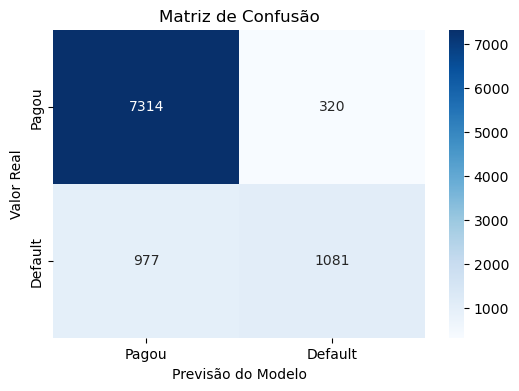

In [12]:
# Plotando a matriz de confusão
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pagou', 'Default'], yticklabels=['Pagou', 'Default'])
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')
plt.title('Matriz de Confusão')
plt.show()

Calculando a AUC

AUC (Area Under the Curve): Mede a capacidade do modelo em classificar corretamente as classes. Valores próximos a 1 indicam um modelo com bom desempenho.

In [13]:
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = binary_evaluator.evaluate(predictions)
print(f"AUC: {auc:.2f}")

AUC: 0.86


Extraindo as probabilidades e labels

In [14]:
probabilities = predictions.select('probability', 'label').collect()
probs = np.array([row['probability'][1] for row in probabilities])
labels = np.array([row['label'] for row in probabilities])

Calculando a curva ROC usando scikit-learn

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

Plotando a Curva ROC

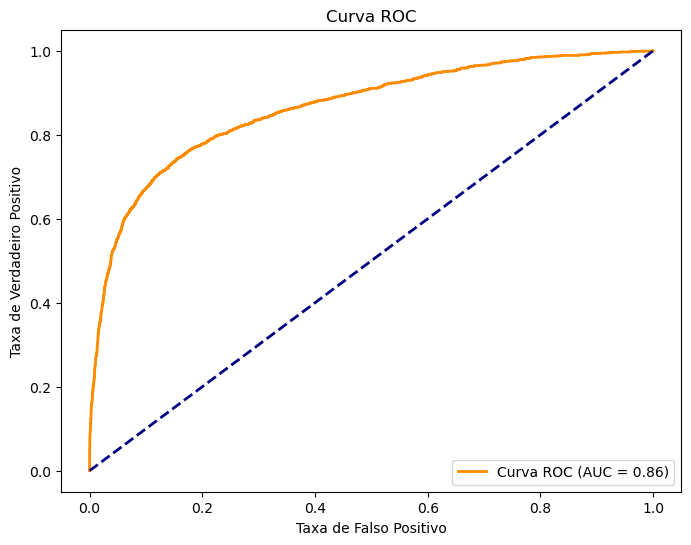

In [16]:
# Plotando a Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Análise dos Coeficientes do Modelo

Importância das Variáveis

In [17]:
# Extraindo os coeficientes do modelo
coefficients = model.coefficients.toArray()


# Obtendo os nomes das features
# O atributo 'features' não carrega os nomes das colunas, então precisamos recuperá-los
# Usando o atributo 'attributes' do schema

attrs = sorted(
    (attr["idx"], attr["name"]) 
    for attr in (train_data
                 .schema["features"]
                 .metadata["ml_attr"]["attrs"]["numeric"] 
                 + train_data
                 .schema["features"]
                 .metadata["ml_attr"]["attrs"].get("binary", []) 
                 + train_data
                 .schema["features"]
                 .metadata["ml_attr"]["attrs"].get("categorical", []))
)

features_names = [name for idx, name in attrs]

coeff_df = pd.DataFrame({
    'Feature': features_names,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)


Visualizando os 10 coeficientes mais importantes

In [18]:
# Visualizando os 10 coeficientes mais importantes
print("\nCoeficientes das Variáveis (Top 10):")
print(coeff_df[['Feature', 'Coefficient']].head(10))


Coeficientes das Variáveis (Top 10):
                              Feature  Coefficient
20                   loan_grade_vec_G    19.491065
5                 loan_percent_income    12.381365
19                   loan_grade_vec_F     2.708141
18                   loan_grade_vec_E     2.313512
17                   loan_grade_vec_D     1.930899
7                       is_home_owner    -1.093385
14                   loan_grade_vec_A    -0.843737
10            loan_intent_vec_VENTURE    -0.633440
12  loan_intent_vec_DEBTCONSOLIDATION     0.527824
13    loan_intent_vec_HOMEIMPROVEMENT     0.505424


Plotando a Importância das Variáveis

Interpretação:

Os coeficientes positivos indicam que um aumento na variável está associado a um aumento na probabilidade de default.
Os coeficientes negativos indicam que um aumento na variável está associado a uma diminuição na probabilidade de default.
As variáveis com coeficientes de maior magnitude (positiva ou negativa) têm maior impacto nas previsões do modelo.

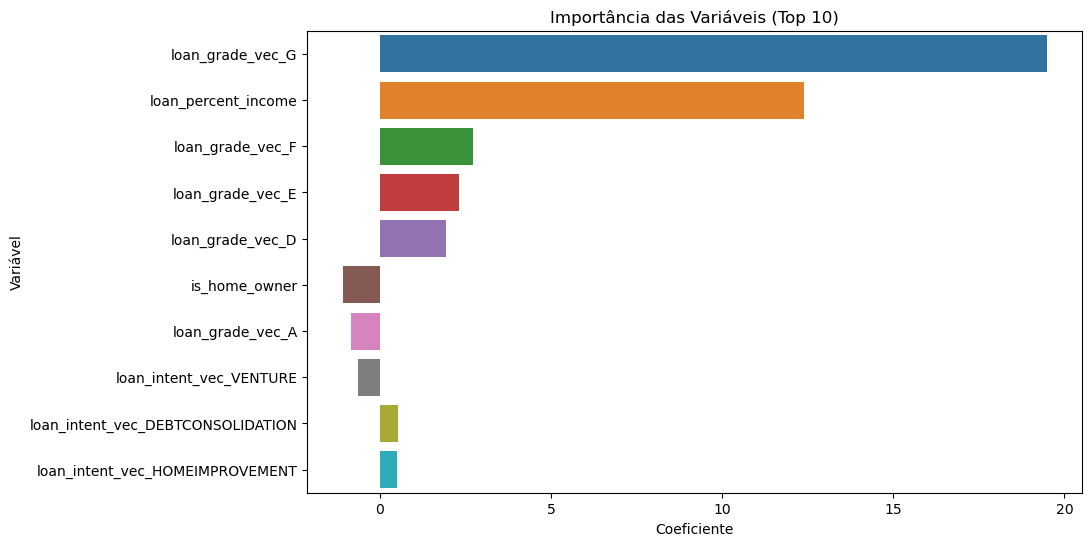

In [19]:
# Plotando a Importância das Variáveis
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df.head(10))
plt.title('Importância das Variáveis (Top 10)')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.show()

# Visualização da Distribuição das Variáveis

In [20]:
# Carregando o DataFrame original antes da transformação
df_original_gold = spark.read.parquet(gold_file_path)

# Exibindo as colunas disponíveis no DataFrame para verificar a presença de 'loan_int_rate' e outras colunas esperadas
print("Colunas no DataFrame original:", df_original_gold.columns)

# Definindo as colunas que queremos verificar
expected_columns = ['loan_int_rate', 'label', 'person_age', 'person_income']

# Verificando quais colunas estão presentes e quais estão faltando
present_columns = [col for col in expected_columns if col in df_original_gold.columns]
missing_columns = [col for col in expected_columns if col not in df_original_gold.columns]

print("\nColunas presentes:", present_columns)
if missing_columns:
    print("Colunas faltantes:", missing_columns)
else:
    print("Todas as colunas esperadas estão presentes.")

# Exibindo uma amostra dos dados para revisão
print("\nAmostra dos dados do DataFrame original antes da transformação:")
df_original_gold.show(5)

Colunas no DataFrame original: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'is_home_owner', 'features', 'label']

Colunas presentes: ['loan_int_rate', 'label', 'person_age', 'person_income']
Todas as colunas esperadas estão presentes.

Amostra dos dados do DataFrame original antes da transformação:
+----------+-------------+-----------------+---------+-------------+-------------------+--------------------------+-------------+--------------------+-----+
|person_age|person_income|person_emp_length|loan_amnt|loan_int_rate|loan_percent_income|cb_person_cred_hist_length|is_home_owner|            features|label|
+----------+-------------+-----------------+---------+-------------+-------------------+--------------------------+-------------+--------------------+-----+
|        22|      59000.0|            123.0|  35000.0|        16.02|               0.59|                         3|            0|(23,[0,1

In [21]:
# Amostrando os dados para conversão em pandas (evitar problemas de memória)
df_original_pd = df_original_gold.sample(fraction=0.1, seed=42).toPandas()

Verifique se 'loan_int_rate' está presente


Coluna 'loan_int_rate' e 'label' encontradas. Prosseguindo com a visualização.


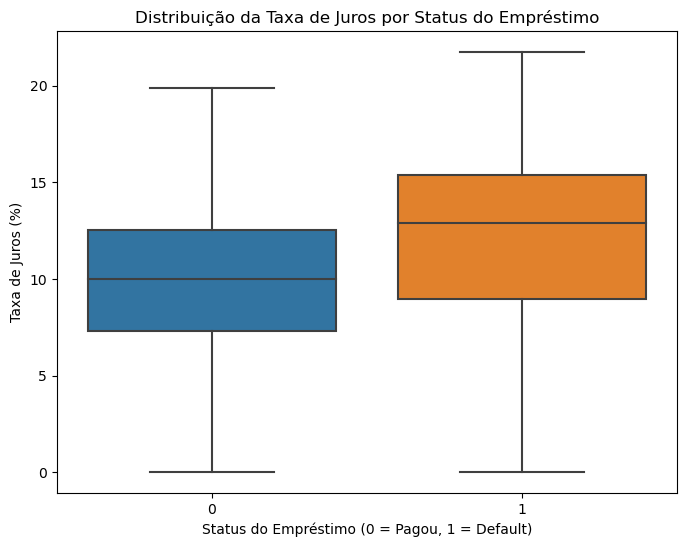

In [22]:
# Verifique se 'loan_int_rate' está presente antes de prosseguir com a visualização
if 'loan_int_rate' in df_original_pd.columns and 'label' in df_original_pd.columns:
    print("\nColuna 'loan_int_rate' e 'label' encontradas. Prosseguindo com a visualização.")
    
    # Distribuição da Taxa de Juros por Status do Empréstimo
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y='loan_int_rate', data=df_original_pd)
    plt.title('Distribuição da Taxa de Juros por Status do Empréstimo')
    plt.xlabel('Status do Empréstimo (0 = Pagou, 1 = Default)')
    plt.ylabel('Taxa de Juros (%)')
    plt.show()
else:
    # Informando quais colunas estão ausentes e são necessárias para a visualização
    missing_for_viz = [col for col in ['loan_int_rate', 'label'] if col not in df_original_pd.columns]
    print(f"\nAs seguintes colunas necessárias para a visualização estão faltando: {missing_for_viz}")

Distribuição da Taxa de Juros por Status do Empréstimo

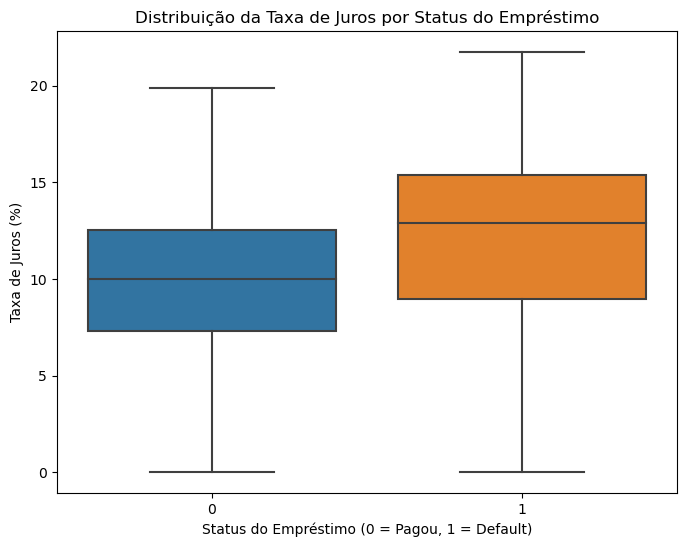

In [23]:
# Distribuição da Taxa de Juros por Status do Empréstimo
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='loan_int_rate', data=df_original_pd)
plt.title('Distribuição da Taxa de Juros por Status do Empréstimo')
plt.xlabel('Status do Empréstimo (0 = Pagou, 1 = Default)')
plt.ylabel('Taxa de Juros (%)')
plt.show()

# Distribuição do Percentual de Renda Comprometida por Status do Empréstimo

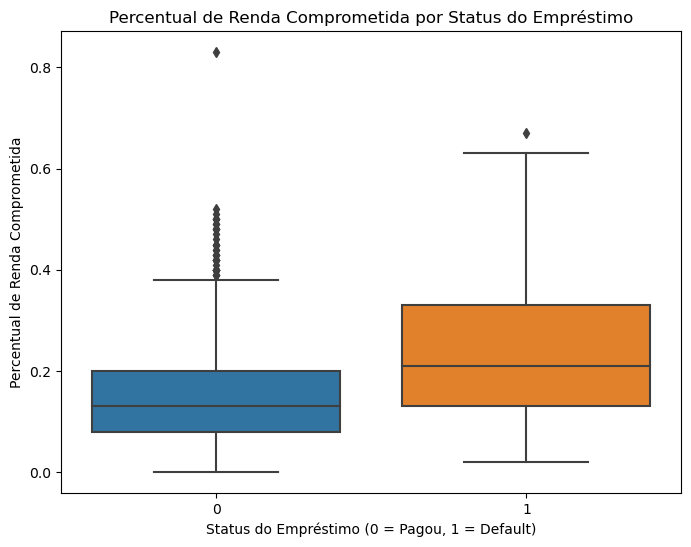

In [24]:
# Distribuição do Percentual de Renda Comprometida por Status do Empréstimo
plt.figure(figsize=(8,6))
sns.boxplot(x='label', y='loan_percent_income', data=df_original_pd)
plt.title('Percentual de Renda Comprometida por Status do Empréstimo')
plt.xlabel('Status do Empréstimo (0 = Pagou, 1 = Default)')
plt.ylabel('Percentual de Renda Comprometida')
plt.show()

Identificação dos Fatores de Risco
Com base nos coeficientes do modelo, podemos identificar quais variáveis contribuem mais para o risco de crédito.

Análise dos Principais Fatores:
Taxa de Juros do Empréstimo (loan_int_rate):

Coeficiente positivo: Taxas de juros mais altas estão associadas a um maior risco de default.
Interpretação: Clientes com taxas de juros mais altas podem ter maior dificuldade em pagar o empréstimo.
Percentual da Renda Comprometida com o Empréstimo (loan_percent_income):

Coeficiente positivo: Quanto maior o percentual da renda comprometida, maior o risco.
Interpretação: Clientes que comprometem uma grande parte de sua renda com o empréstimo têm maior probabilidade de inadimplência.
Histórico de Crédito (cb_person_cred_hist_length):

Coeficiente negativo: Um histórico de crédito mais longo está associado a um menor risco.
Interpretação: Clientes com um histórico de crédito mais longo geralmente têm mais experiência em lidar com crédito e podem ser considerados menos arriscados.
Intenção do Empréstimo (loan_intent):

Variáveis dummy indicando o propósito do empréstimo (e.g., loan_intent_DEBTCONSOLIDATION).
Certas intenções podem estar associadas a maiores riscos.
Nota de Crédito (loan_grade):

Variáveis dummy para diferentes categorias de nota de crédito.
Notas mais baixas (e.g., loan_grade_G) estão associadas a maior risco.

Visualização da Distribuição das Variáveis
Podemos explorar a distribuição das variáveis mais importantes e como elas diferem entre os clientes que pagaram e os que não pagaram o empréstimo.

Conclusões e Insights
Desempenho do Modelo:

Acurácia: O modelo possui uma acurácia de aproximadamente X% (substitua pelo valor real obtido).
AUC: A área sob a curva ROC é de Y (substitua pelo valor real), indicando que o modelo tem um bom poder discriminativo.
Principais Fatores de Risco:

Taxa de Juros Elevada: Clientes com taxas de juros mais altas têm maior risco de default.
Alto Comprometimento da Renda: Um alto percentual da renda comprometida com o empréstimo aumenta o risco.
Curto Histórico de Crédito: Clientes com um histórico de crédito mais curto estão associados a um risco maior.
Intenção do Empréstimo: Certos propósitos do empréstimo, como consolidação de dívidas, podem estar associados a maiores riscos.
Recomendações:

Avaliação Rigorosa: Realizar uma análise mais detalhada para clientes com taxas de juros altas e alto comprometimento de renda.
Políticas de Crédito: Revisar as políticas para aprovar empréstimos com base nos fatores de risco identificados.
Educação Financeira: Oferecer programas de educação financeira para clientes com histórico de crédito curto.

Salvando Resultados do Modelo em Parquet para Consumo no Power BI

In [27]:
# Salvando Resultados do Modelo em Parquet para Consumo no Power BI

# Diretório onde os resultados serão salvos
business_dir = os.path.join(project_root, 'business', 'results')
os.makedirs(business_dir, exist_ok=True)

# Salvando previsões do modelo
predictions_output_path = os.path.join(business_dir, 'credit_risk_predictions.parquet')
predictions.select('label', 'prediction', 'probability').write.mode('overwrite').parquet(predictions_output_path)
print(f"Previsões do modelo salvas em: {predictions_output_path}")

# Calculando a AUC, se ainda não foi calculada
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc_score = binary_evaluator.evaluate(predictions)
print(f"AUC calculada: {auc_score}")

# Salvando métricas do modelo em formato DataFrame para Power BI
metrics_data = [
    ("Accuracy", float(accuracy)),
    ("AUC", float(auc_score))  # Usando auc_score como valor numérico
]
metrics_schema = ["Metric", "Value"]

# Criando o DataFrame PySpark para métricas e salvando em Parquet
metrics_spark_df = spark.createDataFrame(metrics_data, schema=metrics_schema)
metrics_output_path = os.path.join(business_dir, 'credit_risk_metrics.parquet')
metrics_spark_df.write.mode('overwrite').parquet(metrics_output_path)
print(f"Métricas do modelo salvas em: {metrics_output_path}")

# Salvando coeficientes das variáveis do modelo para análise em Power BI
coefficients_output_path = os.path.join(business_dir, 'credit_risk_coefficients.parquet')
coeff_spark_df = spark.createDataFrame(coeff_df)
coeff_spark_df.write.mode('overwrite').parquet(coefficients_output_path)
print(f"Coeficientes das variáveis salvos em: {coefficients_output_path}")

# Finalizando a SparkSession
spark.stop()


Previsões do modelo salvas em: /home/savidotti/programmers/credit-risk-analysis/business/results/credit_risk_predictions.parquet
AUC calculada: 0.863844882988565


Métricas do modelo salvas em: /home/savidotti/programmers/credit-risk-analysis/business/results/credit_risk_metrics.parquet
Coeficientes das variáveis salvos em: /home/savidotti/programmers/credit-risk-analysis/business/results/credit_risk_coefficients.parquet
